# Quantitative Evaluation: PSM Segmentation Metrics

This notebook computes standard segmentation metrics (Dice Score, IoU) comparing:
- **Our Method**: Weakly supervised Random Forest with multi-scale texture features
- **Baseline 1**: Otsu thresholding
- **Baseline 2**: Hysteresis thresholding

Against **expert annotations** from the Oates Lab at EPFL.

## Requirements
- Expert GT masks in `Ground_Truth_Masks/` (2D TIF files, Z-slice 188)
- Our RF predictions in `mask_santi/` (3D TIF files)
- Raw Channel 3 data for baseline computation

## Expected Output
- `real_metrics_results.csv`: Per-timepoint metrics
- `Report Latex/figures/baseline_comparison.png`: Visual comparison figure
- LaTeX formatted table for metrics


In [1]:
# Cell 1: Imports
import numpy as np
from pathlib import Path
from PIL import Image
import tifffile as tiff
from skimage.filters import threshold_otsu, apply_hysteresis_threshold
from skimage.morphology import binary_closing, disk, remove_small_objects
from skimage.transform import resize
from scipy.ndimage import binary_fill_holes  # Fixed: was in wrong module
import matplotlib.pyplot as plt
import pandas as pd

print("[OK] Imports loaded")


[OK] Imports loaded


In [2]:
# Cell 2: Configuration
# ============================================================================
# USER CONFIGURATION (CHANGE THESE)
# ============================================================================
MASK_FOLDER = "mask_santi"                    # Folder with your RF masks
GT_FOLDER = "Ground_Truth_Masks"              # Folder with expert GT masks

# ============================================================================
# AUTO-DETECT DATA LOCATION (usually no need to change)
# ============================================================================
import os
current_dir = Path(".")
parent_dir = Path("..")

# Try to find the data directories
if (current_dir / GT_FOLDER).exists():
    BASE_DIR = current_dir
elif (parent_dir / GT_FOLDER).exists():
    BASE_DIR = parent_dir
else:
    BASE_DIR = Path("..")
    print(f"[WARNING] Could not find '{GT_FOLDER}'. Set BASE_DIR manually.")

# Paths relative to BASE_DIR
GT_MASK_DIR = BASE_DIR / GT_FOLDER            # Expert binary masks
OUR_MASK_DIR = BASE_DIR / MASK_FOLDER         # Our RF predictions (3D TIF)
RAW_DIR = BASE_DIR                             # Raw Channel 3 TIFs (3D)

Z_SLICE = 188  # Z-slice to extract from our 3D masks

# Selected "good" GT masks (verified to exist and have proper PSM shapes)
GOOD_TIMEPOINTS = [100, 110, 180, 190, 200]

# Training frames (used for RF training)
TRAIN_FRAMES = {1, 30, 70, 120, 140, 180, 200}

# Determine which good timepoints are in test vs train
TEST_TIMEPOINTS = [t for t in GOOD_TIMEPOINTS if t not in TRAIN_FRAMES]
TRAIN_EVAL_TIMEPOINTS = [t for t in GOOD_TIMEPOINTS if t in TRAIN_FRAMES]

# Verify paths exist
print(f"[CONFIG] BASE_DIR: {BASE_DIR.resolve()}")
print(f"[CONFIG] GT masks dir: {GT_MASK_DIR} (exists: {GT_MASK_DIR.exists()})")
print(f"[CONFIG] Our masks dir: {OUR_MASK_DIR} (exists: {OUR_MASK_DIR.exists()})")
print(f"[CONFIG] Raw data dir: {RAW_DIR} (exists: {RAW_DIR.exists()})")
print(f"[OK] GT masks to evaluate: {GOOD_TIMEPOINTS}")
print(f"[OK] Test timepoints (NOT in training): {TEST_TIMEPOINTS}")
print(f"[OK] Train timepoints (for reference only): {TRAIN_EVAL_TIMEPOINTS}")


[CONFIG] BASE_DIR: /data/241211-Her1YFPxUtrCh+H2BCer-HIGHRES/20241211_181907_Experiment/Position 3_Settings 1
[CONFIG] GT masks dir: ../Ground_Truth_Masks (exists: True)
[CONFIG] Our masks dir: ../mask_santi (exists: True)
[CONFIG] Raw data dir: .. (exists: True)
[OK] GT masks to evaluate: [100, 110, 180, 190, 200]
[OK] Test timepoints (NOT in training): [100, 110, 190]
[OK] Train timepoints (for reference only): [180, 200]


In [3]:
# Cell 3: Helper functions (simplified for TIF masks)

def dice_score(pred, gt):
    """Dice coefficient = 2*|A∩B| / (|A|+|B|)"""
    pred_bool = pred.astype(bool)
    gt_bool = gt.astype(bool)
    intersection = np.logical_and(pred_bool, gt_bool).sum()
    total = pred_bool.sum() + gt_bool.sum()
    if total == 0:
        return 1.0
    return 2 * intersection / total


def iou_score(pred, gt):
    """IoU (Jaccard) = |A∩B| / |A∪B|"""
    pred_bool = pred.astype(bool)
    gt_bool = gt.astype(bool)
    intersection = np.logical_and(pred_bool, gt_bool).sum()
    union = np.logical_or(pred_bool, gt_bool).sum()
    if union == 0:
        return 1.0
    return intersection / union


def load_gt_mask_slice(t, z_slice=Z_SLICE):
    """Load expert GT mask (already 2D, represents Z=188)."""
    gt_path = GT_MASK_DIR / f"t{t:04d}_gt_mask.tif"
    if not gt_path.exists():
        return None
    gt_img = tiff.imread(str(gt_path))
    # GT masks are already 2D (single slice)
    if len(gt_img.shape) == 3:
        gt_img = gt_img[min(z_slice, gt_img.shape[0]-1)]
    return (gt_img > 0).astype(bool)


def load_our_mask_slice(t, z_slice=Z_SLICE):
    """Load our RF prediction mask (3D TIF) and extract Z slice."""
    our_path = OUR_MASK_DIR / f"mask_t{t:04d}_Channel 3.tif"
    if not our_path.exists():
        return None
    our_vol = tiff.imread(str(our_path))
    if len(our_vol.shape) == 3:
        our_slice = our_vol[z_slice]
    else:
        our_slice = our_vol
    return (our_slice > 0).astype(bool)


def apply_otsu_baseline(raw_slice):
    """Otsu thresholding on 2D slice."""
    if raw_slice.max() == 0:
        return np.zeros_like(raw_slice, dtype=bool)
    nz = raw_slice[raw_slice > 0]
    if nz.size < 100:
        return np.zeros_like(raw_slice, dtype=bool)
    thresh = threshold_otsu(nz)
    binary = raw_slice > thresh
    binary = remove_small_objects(binary, min_size=500)
    return binary.astype(bool)


def apply_hysteresis_baseline(raw_slice):
    """Hysteresis thresholding on 2D slice."""
    if raw_slice.max() == 0:
        return np.zeros_like(raw_slice, dtype=bool)
    nz = raw_slice[raw_slice > 0]
    if nz.size < 100:
        return np.zeros_like(raw_slice, dtype=bool)
    low = np.percentile(nz, 70)
    high = np.percentile(nz, 90)
    binary = apply_hysteresis_threshold(raw_slice.astype(float), low, high)
    binary = remove_small_objects(binary, min_size=500)
    return binary.astype(bool)


print("[OK] Helper functions defined")


[OK] Helper functions defined


In [4]:
# Cell 4: Compute metrics for all GOOD timepoints

results = []

print("="*70)
print("COMPUTING METRICS FOR GOOD GT MASKS")
print("="*70)

for t in GOOD_TIMEPOINTS:
    print(f"\nt={t:04d}:", end=" ")
    
    # 1) Load expert GT mask (TIF)
    gt_mask = load_gt_mask_slice(t, Z_SLICE)
    if gt_mask is None:
        print("[SKIP] No GT mask")
        continue
    print(f"GT={gt_mask.sum():,}px", end=" | ")
    
    # 2) Load our RF prediction mask (TIF)
    our_mask = load_our_mask_slice(t, Z_SLICE)
    if our_mask is None:
        print("[SKIP] No our mask")
        continue
    print(f"Ours={our_mask.sum():,}px", end=" | ")
    
    # 3) Load raw Channel 3 for baselines
    raw_path = RAW_DIR / f"t{t:04d}_Channel 3.tif"
    if not raw_path.exists():
        print(f"[SKIP] No raw")
        continue
    
    raw_vol = tiff.imread(str(raw_path))
    raw_slice = raw_vol[Z_SLICE]
    
    # Resize if needed to match GT dimensions
    if raw_slice.shape != gt_mask.shape:
        raw_slice = resize(raw_slice, gt_mask.shape, preserve_range=True).astype(raw_slice.dtype)
    if our_mask.shape != gt_mask.shape:
        our_mask = resize(our_mask.astype(float), gt_mask.shape, preserve_range=True) > 0.5
    
    # Compute baselines
    otsu_mask = apply_otsu_baseline(raw_slice)
    hyst_mask = apply_hysteresis_baseline(raw_slice)
    
    # Resize baselines if needed
    if otsu_mask.shape != gt_mask.shape:
        otsu_mask = resize(otsu_mask.astype(float), gt_mask.shape, preserve_range=True) > 0.5
    if hyst_mask.shape != gt_mask.shape:
        hyst_mask = resize(hyst_mask.astype(float), gt_mask.shape, preserve_range=True) > 0.5
    
    # 4) Compute all metrics
    is_test = t not in TRAIN_FRAMES
    
    metrics = {
        "Timepoint": t,
        "Split": "Test" if is_test else "Train",
        "GT_px": int(gt_mask.sum()),
        "RF_Dice": dice_score(our_mask, gt_mask),
        "RF_IoU": iou_score(our_mask, gt_mask),
        "Otsu_Dice": dice_score(otsu_mask, gt_mask),
        "Otsu_IoU": iou_score(otsu_mask, gt_mask),
        "Hyst_Dice": dice_score(hyst_mask, gt_mask),
        "Hyst_IoU": iou_score(hyst_mask, gt_mask),
    }
    results.append(metrics)
    
    print(f"RF={metrics['RF_Dice']:.3f} Otsu={metrics['Otsu_Dice']:.3f} Hyst={metrics['Hyst_Dice']:.3f}")

print("\n" + "="*70)
print(f"Processed {len(results)} timepoints")
print("="*70)


COMPUTING METRICS FOR GOOD GT MASKS

t=0100: GT=3,481px | Ours=111,070px | RF=0.685 Otsu=0.242 Hyst=0.180

t=0110: GT=3,082px | Ours=109,336px | RF=0.719 Otsu=0.199 Hyst=0.148

t=0180: GT=2,497px | Ours=66,520px | RF=0.524 Otsu=0.210 Hyst=0.130

t=0190: GT=2,462px | Ours=68,826px | RF=0.633 Otsu=0.286 Hyst=0.151

t=0200: GT=2,334px | Ours=75,315px | RF=0.636 Otsu=0.289 Hyst=0.144

Processed 5 timepoints


In [5]:
# Cell 5: Summary and Results Table

df = pd.DataFrame(results)

if len(df) == 0:
    print("[ERROR] No results computed! Check that:")
    print(f"  1. GT masks exist in: {GT_MASK_DIR}")
    print(f"  2. Our masks exist in: {OUR_MASK_DIR}")
    print(f"  3. Raw files exist in: {RAW_DIR}")
    print("  4. Run Cell 2 to verify paths are correct")
else:
    print("\n" + "="*70)
    print("DETAILED RESULTS PER TIMEPOINT")
    print("="*70)
    print(df.to_string(index=False))
    
    # Separate test and train
    df_test = df[df["Split"] == "Test"]
    df_train = df[df["Split"] == "Train"]
    
    # Summary for ALL evaluated frames
    print("\n" + "="*70)
    print(f"SUMMARY - ALL {len(df)} EVALUATED FRAMES")
    print("="*70)
    
    for method, dice_col, iou_col in [
        ("Random Forest (Ours)", "RF_Dice", "RF_IoU"),
        ("Otsu Threshold", "Otsu_Dice", "Otsu_IoU"),
        ("Hysteresis Threshold", "Hyst_Dice", "Hyst_IoU"),
    ]:
        dice_mean = df[dice_col].mean()
        dice_std = df[dice_col].std()
        iou_mean = df[iou_col].mean()
        print(f"{method:25s} | Dice: {dice_mean:.3f} +/- {dice_std:.3f} | IoU: {iou_mean:.3f}")
    
    # If we have test frames, show them separately
    if len(df_test) > 0:
        print("\n" + "="*70)
        print(f"TEST SET ONLY ({len(df_test)} frames NOT in training)")
        print("="*70)
        for method, dice_col, iou_col in [
            ("Random Forest (Ours)", "RF_Dice", "RF_IoU"),
            ("Otsu Threshold", "Otsu_Dice", "Otsu_IoU"),
            ("Hysteresis Threshold", "Hyst_Dice", "Hyst_IoU"),
        ]:
            dice_mean = df_test[dice_col].mean()
            dice_std = df_test[dice_col].std()
            print(f"{method:25s} | Dice: {dice_mean:.3f} +/- {dice_std:.3f}")
    
    # Save results
    df.to_csv("real_metrics_results.csv", index=False)
    print("\n[OK] Saved to real_metrics_results.csv")



DETAILED RESULTS PER TIMEPOINT
 Timepoint Split  GT_px  RF_Dice   RF_IoU  Otsu_Dice  Otsu_IoU  Hyst_Dice  Hyst_IoU
       100  Test   3481 0.685043 0.520962   0.241963  0.137632   0.179790  0.098774
       110  Test   3082 0.719233 0.561565   0.199319  0.110691   0.148262  0.080067
       180 Train   2497 0.524067 0.355075   0.210163  0.117420   0.129540  0.069256
       190  Test   2462 0.632710 0.462748   0.285622  0.166604   0.150995  0.081663
       200 Train   2334 0.635902 0.466171   0.289131  0.168997   0.143712  0.077419

SUMMARY - ALL 5 EVALUATED FRAMES
Random Forest (Ours)      | Dice: 0.639 +/- 0.074 | IoU: 0.473
Otsu Threshold            | Dice: 0.245 +/- 0.042 | IoU: 0.140
Hysteresis Threshold      | Dice: 0.150 +/- 0.018 | IoU: 0.081

TEST SET ONLY (3 frames NOT in training)
Random Forest (Ours)      | Dice: 0.679 +/- 0.044
Otsu Threshold            | Dice: 0.242 +/- 0.043
Hysteresis Threshold      | Dice: 0.160 +/- 0.017

[OK] Saved to real_metrics_results.csv


In [6]:
# Cell 6: Summary statistics

print('METRICS SUMMARY (mean +/- std)')
print('-' * 40)

rf_dice = df['RF_Dice'].mean()
rf_std = df['RF_Dice'].std()
otsu_dice = df['Otsu_Dice'].mean()
hyst_dice = df['Hyst_Dice'].mean()

print(f'RF:         {rf_dice:.3f} +/- {rf_std:.3f}')
print(f'Otsu:       {otsu_dice:.3f}')
print(f'Hysteresis: {hyst_dice:.3f}')

best_baseline = max(otsu_dice, hyst_dice)
improvement = (rf_dice - best_baseline) / best_baseline * 100
print(f'Improvement: {improvement:+.1f}%')


METRICS SUMMARY (mean +/- std)
----------------------------------------
RF:         0.639 +/- 0.074
Otsu:       0.245
Hysteresis: 0.150
Improvement: +160.7%


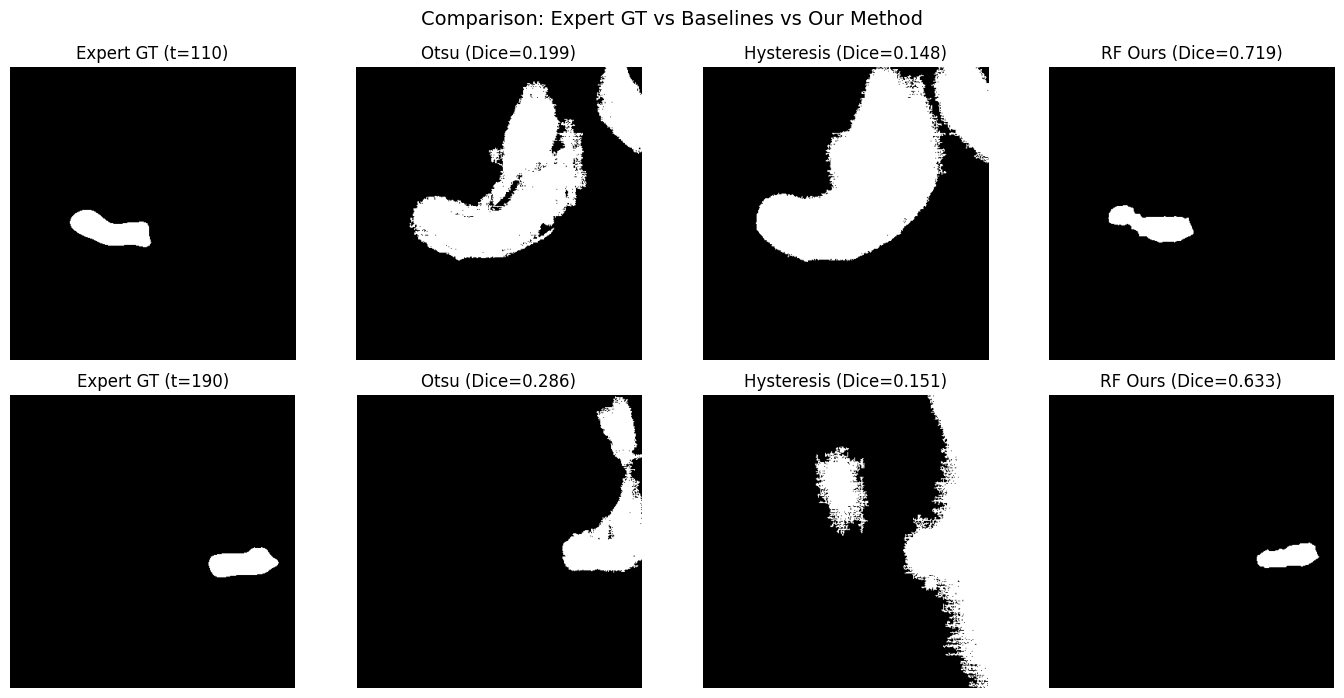

[OK] Saved to Report Latex/figures/baseline_comparison.png


In [7]:
# Cell 7: Visualize comparison

import os
os.makedirs("Report Latex/figures", exist_ok=True)

# Selected frames
REPORT_FRAMES = [110, 190]
viz_frames = [t for t in REPORT_FRAMES if t in df["Timepoint"].tolist()]
n_viz = len(viz_frames)

if n_viz == 0:
    print("[ERROR] No frames to visualize")
else:
    fig, axes = plt.subplots(n_viz, 4, figsize=(14, 3.5*n_viz))
    if n_viz == 1:
        axes = axes.reshape(1, -1)
    
    for i, t in enumerate(viz_frames):
        # Load masks using our helper functions
        gt_mask = load_gt_mask_slice(t, Z_SLICE)
        our_mask = load_our_mask_slice(t, Z_SLICE)
        
        if gt_mask is None or our_mask is None:
            print(f"[SKIP] t={t} - missing mask")
            continue
        
        # Load raw for baselines
        raw_path = RAW_DIR / f"t{t:04d}_Channel 3.tif"
        raw_vol = tiff.imread(str(raw_path))
        raw_slice = raw_vol[Z_SLICE]
        
        # Resize if needed
        if raw_slice.shape != gt_mask.shape:
            raw_slice = resize(raw_slice, gt_mask.shape, preserve_range=True).astype(raw_slice.dtype)
        if our_mask.shape != gt_mask.shape:
            our_mask = resize(our_mask.astype(float), gt_mask.shape, preserve_range=True) > 0.5
        
        otsu_mask = apply_otsu_baseline(raw_slice)
        hyst_mask = apply_hysteresis_baseline(raw_slice)
        
        if otsu_mask.shape != gt_mask.shape:
            otsu_mask = resize(otsu_mask.astype(float), gt_mask.shape, preserve_range=True) > 0.5
        if hyst_mask.shape != gt_mask.shape:
            hyst_mask = resize(hyst_mask.astype(float), gt_mask.shape, preserve_range=True) > 0.5
        
        row = df[df["Timepoint"] == t].iloc[0]
        
        # Plot
        axes[i, 0].imshow(gt_mask, cmap='gray')
        axes[i, 0].set_title(f"Expert GT (t={t})")
        
        axes[i, 1].imshow(otsu_mask, cmap='gray')
        axes[i, 1].set_title(f"Otsu (Dice={row['Otsu_Dice']:.3f})")
        
        axes[i, 2].imshow(hyst_mask, cmap='gray')
        axes[i, 2].set_title(f"Hysteresis (Dice={row['Hyst_Dice']:.3f})")
        
        axes[i, 3].imshow(our_mask, cmap='gray')
        axes[i, 3].set_title(f"RF Ours (Dice={row['RF_Dice']:.3f})")
        
        for ax in axes[i]:
            ax.axis('off')
    
    # Adjust layout to prevent text overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at top for suptitle
    plt.suptitle("Comparison: Expert GT vs Baselines vs Our Method", fontsize=14, y=0.99)
    plt.savefig("Report Latex/figures/baseline_comparison.png", dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print("[OK] Saved to Report Latex/figures/baseline_comparison.png")
